In [1]:
import sys
sys.path.insert(0, r'C:\Users\nobre\OneDrive\Documents\Programming\Brasileirao Data Vis')

In [2]:
import requests
import pandas as pd
import bar_chart_race as bcr

#import os
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
#import json
#import csv

In [3]:
# Constants
## UPDATE FINAL ROUND WHENEVER NECESSARY
API_BASE_URL = "https://api.globoesporte.globo.com/tabela/d1a37fa4-e948-43a6-ba53-ab24ab3a45b1/fase/fase-unica-campeonato-brasileiro-2023/rodada/"
csv_filename = "matches.csv"
final_round = 36
first_half = []
for i in range(final_round):
    if i < 19:
        first_half.append(True)
    else:
        first_half.append(False)

In [4]:
# Function to get the results for the first round of a championship
def get_round_results(round):
    endpoint = f"{round}/jogos/"
    response = requests.get(API_BASE_URL + endpoint) # , headers=headers)
    response.encoding = 'utf-8'
    return response.json()

In [5]:
# define and run test to see if format and length being received are correct
def test__get_round_results():
    response = get_round_results(1)
    if type(response) != type([]):
        print('Error: Response format invalid\nFormat: ', type(response))
        return
    if len(response) != 10:
        print('Error: Response length not correct\nLength: ', len(response))
        return
    print('Tests Passed!')

test__get_round_results()

Tests Passed!


## Two alternatives for saving data
### 1. Save match stats as csv files before creating the pandas dataframe

In [6]:
"""# function that writes all match details in the round to a csv
def add_matches_to_csv(matches_in_round, championship_round_id, csv_filename):

    with open(csv_filename, mode='a', newline='', encoding='utf-8') as file:
        csv_writer = csv.writer(file)

        for match in matches_in_round:
            date = match.get('data_realizacao', '').split('T')[0]
            time = match.get('hora_realizacao', '')
            home_team_name = match.get('equipes', {}).get('mandante', {}).get('nome_popular', '')
            away_team_name = match.get('equipes', {}).get('visitante', {}).get('nome_popular', '')
            home_team_score = match.get('placar_oficial_mandante', '')
            away_team_score = match.get('placar_oficial_visitante', '')
            stadium_name = match.get('sede', {}).get('nome_popular', '')

            csv_writer.writerow([date, time, home_team_name, away_team_name, home_team_score, away_team_score, championship_round_id, stadium_name])

def add_headers_to_csv(csv_filename):
    with open(csv_filename, mode='a', newline='', encoding='utf-8') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(['date', 'time', 'home_team_name', 'away_team_name', 'home_team_score', 'away_team_score', 'championship_round_id', 'stadium_name'])

#function that writes all matches in the championship up to a given round on a csv
def add_all_matches_to_csv(final_round, csv_filename):
    for i in range(1,final_round+1):
        round_results = get_round_results(i)
        add_matches_to_csv(round_results,i,csv_filename)

# write csv file with all match details
add_all_matches_to_csv(33, csv_filename)

# read from csv to pandas for data visualization
all_matches = pd.read_csv(csv_filename) """

"# function that writes all match details in the round to a csv\ndef add_matches_to_csv(matches_in_round, championship_round_id, csv_filename):\n\n    with open(csv_filename, mode='a', newline='', encoding='utf-8') as file:\n        csv_writer = csv.writer(file)\n\n        for match in matches_in_round:\n            date = match.get('data_realizacao', '').split('T')[0]\n            time = match.get('hora_realizacao', '')\n            home_team_name = match.get('equipes', {}).get('mandante', {}).get('nome_popular', '')\n            away_team_name = match.get('equipes', {}).get('visitante', {}).get('nome_popular', '')\n            home_team_score = match.get('placar_oficial_mandante', '')\n            away_team_score = match.get('placar_oficial_visitante', '')\n            stadium_name = match.get('sede', {}).get('nome_popular', '')\n\n            csv_writer.writerow([date, time, home_team_name, away_team_name, home_team_score, away_team_score, championship_round_id, stadium_name])\n\nde

### 2. Save match stats to list and then convert it to a pandas dataframe

In [7]:
# Function that adds all match details in the round to a list
def add_matches_to_list(matches_in_round, championship_round_id, matches_list):
    for match in matches_in_round:
        date = match.get('data_realizacao', '').split('T')[0]
        time = match.get('hora_realizacao', '')
        home_team_name = match.get('equipes', {}).get('mandante', {}).get('nome_popular', '')
        away_team_name = match.get('equipes', {}).get('visitante', {}).get('nome_popular', '')
        home_team_score = match.get('placar_oficial_mandante', '')
        away_team_score = match.get('placar_oficial_visitante', '')
        stadium_name = match.get('sede', {}).get('nome_popular', '')

        match_details = {
            'date': date,
            'time': time,
            'home_team_name': home_team_name,
            'away_team_name': away_team_name,
            'home_team_score': home_team_score,
            'away_team_score': away_team_score,
            'championship_round_id': championship_round_id,
            'stadium_name': stadium_name
        }

        matches_list.append(match_details)

# Function that adds all matches in the championship up to a given round to a list
def add_all_matches_to_list(final_round):
    matches_list = []
    for i in range(1, final_round + 1):
        round_results = get_round_results(i)
        add_matches_to_list(round_results, i, matches_list)
    return matches_list

# Collect all match data in a list and convert to pandas DataFrame for data visualization
matches_list = add_all_matches_to_list(final_round)
all_matches = pd.DataFrame(matches_list)

In [8]:
all_matches.head()

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name
0,2023-04-15,16:00,Palmeiras,Cuiabá,2,1,1,Allianz Parque
1,2023-04-15,16:00,América-MG,Fluminense,0,3,1,Independência
2,2023-04-15,18:30,Botafogo,São Paulo,2,1,1,Nilton Santos (Engenhão)
3,2023-04-15,18:30,Bragantino,Bahia,2,1,1,Nabi Abi Chedid
4,2023-04-15,18:30,Athletico-PR,Goiás,2,0,1,Ligga Arena


In [9]:
# Save all team names
team_names = all_matches["home_team_name"].unique()

### Data Storage Target

In the following code we will create a dictionary that will have each club as key and an array of arrays as values. Each array in the array of arrays will have the club's stats at the end of each round.

(Key) - String - Club Name

(Value) - Array of Arrays - for each round, an array with: (Points, Victories, Draws, Losses, Goal Difference, Goals Scored, Goals Suffered)

In [10]:
# Function to calculate the points and other statistics for each team
def calculate_team_stats(df):
    team_stats = {}

    for index, row in df.iterrows():
        home_team = row['home_team_name']
        away_team = row['away_team_name']
        home_score = row['home_team_score']
        away_score = row['away_team_score']
        round_number = row['championship_round_id']

        # Initialize team stats if not already present
        if home_team not in team_stats:
            team_stats[home_team] = []
        if away_team not in team_stats:
            team_stats[away_team] = []

        # Calculate stats for each team
        for team in [home_team, away_team]:
            while len(team_stats[team]) < round_number:
                # Previous round stats or initial stats
                prev_stats = team_stats[team][-1] if team_stats[team] else [0, 0, 0, 0, 0, 0, 0, 0]
                team_stats[team].append(prev_stats.copy())

            # Get current round stats
            current_stats = team_stats[team][-1]

            # Check if scores are NaN
            if pd.isna(home_score) or pd.isna(away_score):
                # Skip updates if scores are NaN, keeping previous stats
                continue

            # Update stats based on this match
            if team == home_team:
                current_stats[1] += 1 if home_score > away_score else 0  # Wins
                current_stats[2] += 1 if home_score == away_score else 0  # Draws
                current_stats[3] += 1 if home_score < away_score else 0  # Losses
                current_stats[4] += home_score - away_score # Goal difference
                current_stats[5] += home_score   # Goals scored
                current_stats[6] += away_score   # Goals suffered
            else:
                current_stats[1] += 1 if away_score > home_score else 0  # Wins
                current_stats[2] += 1 if away_score == home_score else 0  # Draws
                current_stats[3] += 1 if away_score < home_score else 0  # Losses
                current_stats[4] += away_score - home_score # Goal difference
                current_stats[5] += away_score # Goals scored
                current_stats[6] += home_score # Goals suffered

            # Update points (3 for a win, 1 for a draw)
            current_stats[0] = current_stats[1] * 3 + current_stats[2]
            current_stats[7] = round_number

    return team_stats

In [11]:
# write dicstionary for all teams
teams_evolution = calculate_team_stats(all_matches)

### Data Storage Target

In the following code we will create a dictionary that will have each club as key and an array as value. Each element in the array will be the club's points at the end of each round.

(Key) - String - Club Name

(Value) - Array of integers - points at the end of each round

In [12]:
# create simple dictionary following structure above
def return_points(json_dict):
    teams_points = {}
    for key, value in teams_evolution.items():
        teams_points[key] = []
        for array in value:
            teams_points[key].append(array[0])
    return teams_points

### If you want to export the data to use in Flourish, use the code below.

In [13]:
""" # save simple dictionary
teams_points = return_points(teams_evolution)

# Specify the filename for the JSON file
json_filename = 'team_points.json'

# Writing dictionary data to a JSON file
if not(os.path.exists(json_filename)):
    with open(json_filename, 'w', encoding='utf-8') as file:
        json.dump(teams_points, file, ensure_ascii=False, indent=4)
else:
    print('File already exists at: ', json_filename, '\nFunction did not write new data.') """

" # save simple dictionary\nteams_points = return_points(teams_evolution)\n\n# Specify the filename for the JSON file\njson_filename = 'team_points.json'\n\n# Writing dictionary data to a JSON file\nif not(os.path.exists(json_filename)):\n    with open(json_filename, 'w', encoding='utf-8') as file:\n        json.dump(teams_points, file, ensure_ascii=False, indent=4)\nelse:\n    print('File already exists at: ', json_filename, '\nFunction did not write new data.') "

### If you want to plot in python, use the code below

In [14]:
# Save the simpler dictionary
data = return_points(teams_evolution)

# Add the round labels
def add_labels(points_dictionary, number_of_rounds):
    points_dictionary["Round"] = []
    for i in range(number_of_rounds):
        points_dictionary["Round"].append("Rodada " + str(i + 1))

add_labels(data, final_round)

points_df = pd.DataFrame(data)
points_df = points_df.set_index("Round")

In [15]:
points_df.head()

,Palmeiras,Cuiabá,América-MG,Fluminense,Botafogo,São Paulo,Bragantino,Bahia,Athletico-PR,Goiás,Fortaleza,Internacional,Atlético-MG,Vasco,Flamengo,Coritiba,Corinthians,Cruzeiro,Grêmio,Santos
Round,,,,,,,,,,,,,,,,,,,,
Rodada 1,3,0,0,3,3,0,3,0,3,0,1,1,0,3,3,0,3,0,3,0
Rodada 2,4,1,0,6,6,3,4,0,3,3,4,4,1,4,3,0,3,3,3,1
Rodada 3,7,1,0,6,9,4,4,3,3,3,7,7,4,4,3,1,3,6,6,4
Rodada 4,10,4,0,7,12,7,5,6,6,3,8,7,4,5,3,1,4,9,7,4
Rodada 5,13,4,1,10,15,8,6,6,9,3,9,7,7,6,6,2,4,9,7,7


In [16]:
# Define colors for each team
colors = {
    'Palmeiras': '#2c9c3c',
    'Cuiabá': '#edcd15',
    'América-MG': '#0a6b1d',
    'Fluminense': '#4ae068',
    'Botafogo': '#e1e3e1',
    'São Paulo': '#f72d16',
    'Bragantino': '#e6e3e3',
    'Bahia': '#51e6e8',
    'Athletico-PR': '#a32929',
    'Goiás': '#8db584',
    'Fortaleza': '#2e69f2',
    'Internacional': '#f50707',
    'Atlético-MG': '#b0acac',
    'Vasco': '#000000',
    'Flamengo': '#851111',
    'Coritiba': '#1f5908',
    'Corinthians': '#dedede',
    'Cruzeiro': '#0000ff',
    'Grêmio': '#3992db',
    'Santos': '#f5f5f5'
 }

# Creating the bar chart race
bcr.bar_chart_race(
    df=points_df,
    filename=None,
    n_bars=20,
    steps_per_period=20,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_length=1000,
    bar_colors=colors,
    figsize=(5, 3)
)

C:\Users\nobre\OneDrive\Documents\Programming\Brasileirao Data Vis\bar_chart_race\_make_chart.py:936: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
C:\Users\nobre\OneDrive\Documents\Programming\Brasileirao Data Vis\bar_chart_race\_make_chart.py:333: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
C:\Users\nobre\OneDrive\Documents\Programming\Brasileirao Data Vis\bar_chart_race\_make_chart.py:334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [21]:
# Função para organizar lista de times na ordem da tabela

def get_ordered_teams(teams, round):
    ordered_teams = teams
    index = 0
    rodada = round - 1

    while index < len(ordered_teams)-1:

        points_team_a = teams_evolution[ordered_teams[index]][rodada][0]
        points_team_b = teams_evolution[ordered_teams[index + 1]][rodada][0]
        wins_team_a = teams_evolution[ordered_teams[index]][rodada][1]
        wins_team_b = teams_evolution[ordered_teams[index + 1]][rodada][1]
        goal_difference_a = teams_evolution[ordered_teams[index]][rodada][4]
        goal_difference_b = teams_evolution[ordered_teams[index+1]][rodada][4]
        goals_scored_a = teams_evolution[ordered_teams[index]][rodada][5]
        goals_scored_b = teams_evolution[ordered_teams[index+1]][rodada][5]

        if points_team_a > points_team_b:
            index +=1
        elif points_team_a < points_team_b:
            ordered_teams[index], ordered_teams[index + 1] = ordered_teams[index + 1], ordered_teams[index]
            if index != 0:
                index -=1
        else:
            if wins_team_a > wins_team_b:
                index += 1
            elif wins_team_a < wins_team_b:
                ordered_teams[index], ordered_teams[index + 1] = ordered_teams[index + 1], ordered_teams[index]
                if index != 0:
                    index -= 1
            else:
                if goal_difference_a > goal_difference_b:
                    index += 1
                elif goal_difference_a < goal_difference_b:
                    ordered_teams[index], ordered_teams[index + 1] = ordered_teams[index + 1], ordered_teams[index]
                    if index != 0:
                        index -=1
                else:
                    if goals_scored_a > goals_scored_b:
                        index += 1
                    elif goals_scored_a < goals_scored_b:
                        ordered_teams[index], ordered_teams[index + 1] = ordered_teams[index + 1], ordered_teams[index]
                        if index != 0:
                            index -= 1
                    else:
                        index += 1
        
    return ordered_teams

In [27]:
#ordem na rodada atual
ordem_agora = get_ordered_teams(team_names, final_round)

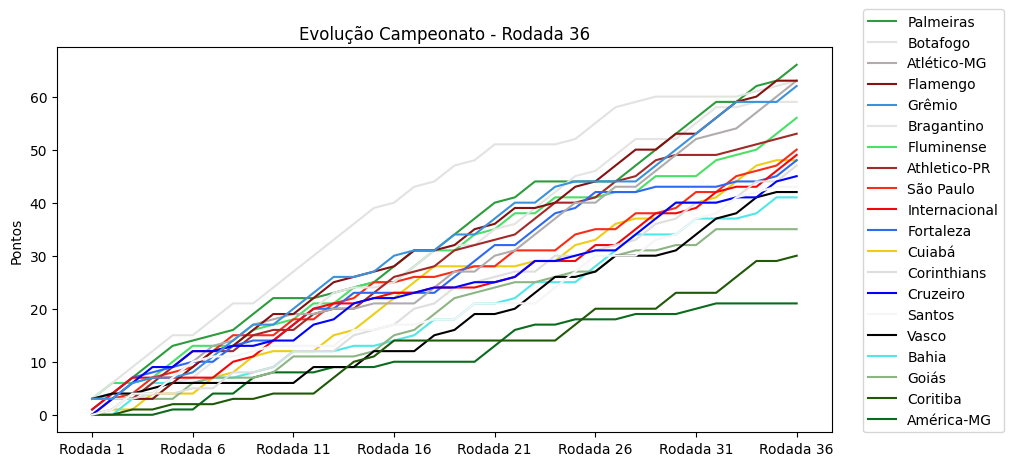

In [29]:
# Every team evolution plot

ax = points_df.plot(kind="line", figsize=(10, 5), color = colors)

handles, labels = ax.get_legend_handles_labels()


ordered_handles = [handles[labels.index(team)] for team in ordem_agora]
ordered_labels = [team for team in ordem_agora]

ax.legend(ordered_handles, ordered_labels, loc=(1.04, 0))

plt.title('Evolução Campeonato - Rodada 36')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(False)

plt.show()

In [24]:
# Ordem da Tabela na 19a rodada:
ordem_19_rodada = get_ordered_teams(team_names, 19)


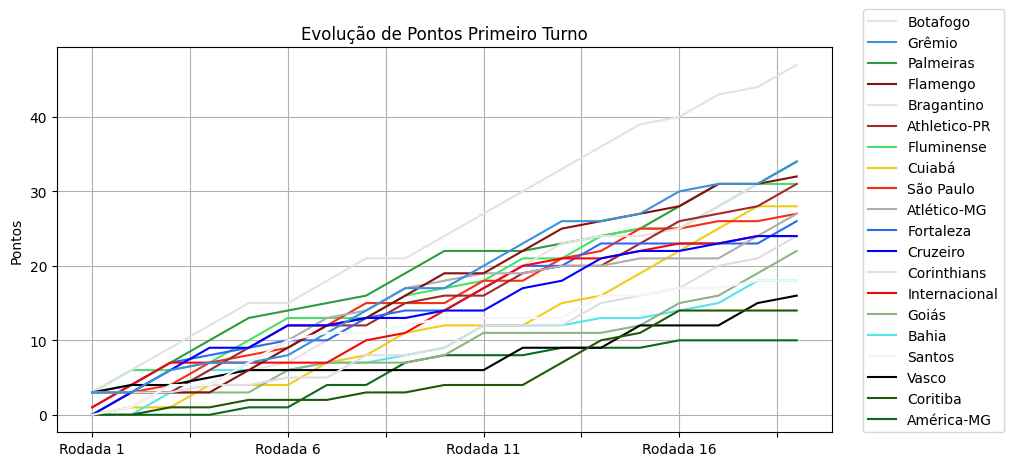

In [25]:
# Every team evolution plot Primeiro Turno
ax = points_df[first_half].plot(kind="line", figsize=(10, 5), color = colors)

handles, labels = ax.get_legend_handles_labels()


ordered_handles = [handles[labels.index(team)] for team in ordem_19_rodada]
ordered_labels = [team for team in ordem_19_rodada]

ax.legend(ordered_handles, ordered_labels, loc=(1.04, 0))

plt.title('Evolução de Pontos Primeiro Turno')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(True)

plt.show()

In [ ]:
#G7 definition
G7_teams = [
    "Palmeiras",
    "Flamengo",
    "Botafogo",
    "Atlético-MG",
    "Bragantino",
    "Grêmio",
    "Fluminense"
]

G7_points_df = points_df[G7_teams].copy()

G7_colors = {key: colors[key] for key in G7_teams if key in colors}

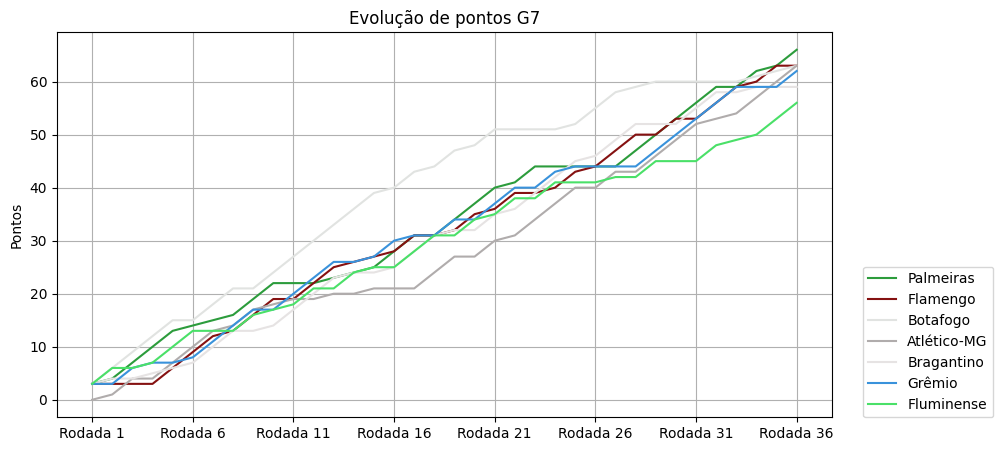

In [ ]:
# G7 evolution plot
G7_points_df.plot(kind="line", figsize=(10, 5), color = G7_colors)

plt.title('Evolução de pontos G7')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(True)
plt.legend(loc=(1.04, 0))

plt.show()

In [ ]:
# Diferença entre Botafogo e Segundo Colocado
lideranca_botafogo = points_df.copy()

lideranca_botafogo["pts segundo"] = lideranca_botafogo.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
lideranca_botafogo["pts lider"] = lideranca_botafogo.max(axis=1)
lideranca_botafogo["pts vantagem"] = 0
lideranca_botafogo["pts vantagem"][lideranca_botafogo["Botafogo"] == lideranca_botafogo["pts lider"]] = lideranca_botafogo["Botafogo"] - lideranca_botafogo["pts segundo"]
lideranca_botafogo["pts vantagem"][lideranca_botafogo["Botafogo"] != lideranca_botafogo["pts lider"]] = lideranca_botafogo["Botafogo"] - lideranca_botafogo ["pts lider"]
lideranca_botafogo[["Botafogo", "pts lider", "pts segundo", "pts vantagem"]]

,Botafogo,pts lider,pts segundo,pts vantagem
Round,,,,
Rodada 1,3,3,3,0
Rodada 2,6,6,6,0
Rodada 3,9,9,7,2
Rodada 4,12,12,10,2
Rodada 5,15,15,13,2
Rodada 6,15,15,14,1
Rodada 7,18,18,15,3
Rodada 8,21,21,16,5
Rodada 9,21,21,19,2


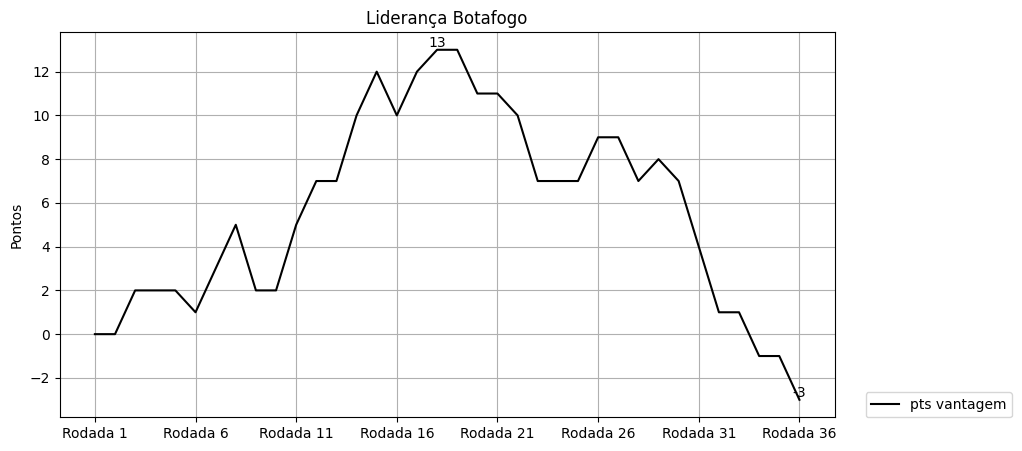

In [ ]:
# Botafogo leadership gap 
ax = lideranca_botafogo.plot(kind="line", y='pts vantagem', figsize=(10, 5), color = 'black')

graph_value_labels = ['Rodada 18', 'Rodada ' + str(final_round)]
for label in graph_value_labels:
    pontos = lideranca_botafogo.loc[label]['pts vantagem']
    x_index = lideranca_botafogo.index.get_loc(label)
    ax.text(x_index, pontos , f'{pontos}', va= 'bottom', ha= 'center')
plt.title('Liderança Botafogo')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(True)
plt.legend(loc=(1.04, 0))

plt.show()

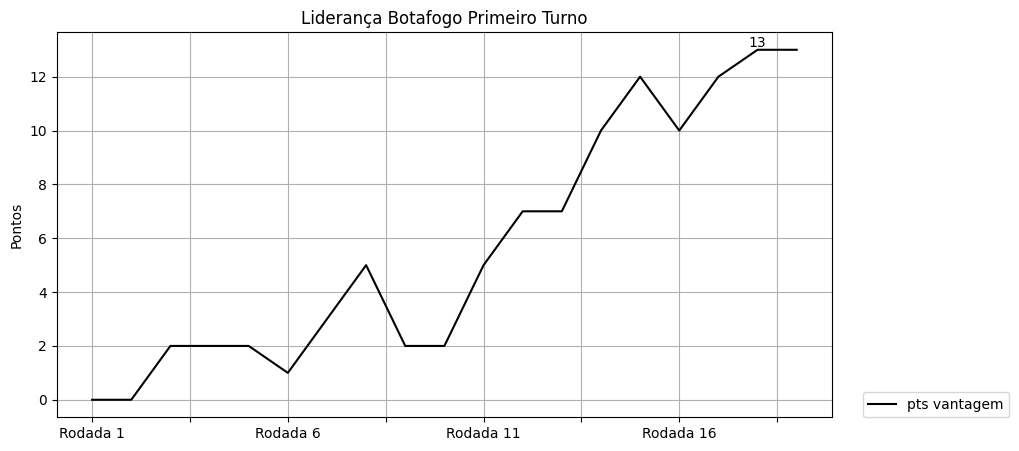

In [ ]:
# Botafogo leadership gap in 1st half
ax = lideranca_botafogo[first_half].plot(kind="line", y='pts vantagem', figsize=(10, 5), color = 'black')

graph_value_labels = ['Rodada 18']
for label in graph_value_labels:
    pontos = lideranca_botafogo.loc[label]['pts vantagem']
    x_index = lideranca_botafogo.index.get_loc(label)
    ax.text(x_index, pontos , f'{pontos}', va= 'bottom', ha= 'center')
plt.title('Liderança Botafogo Primeiro Turno')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(True)
plt.legend(loc=(1.04, 0))

plt.show()

In [ ]:
#Quem era o G4 no primeiro Turno?
points_df.loc['Rodada 19'].sort_values(ascending=False).head(6)

Botafogo      47
Palmeiras     34
Grêmio        34
Bragantino    32
Flamengo      32
Fluminense    31
Name: Rodada 19, dtype: int64

In [ ]:
#Quem tava na frente nos critérios de desempate, Flamengo ou Braga?
print(teams_evolution['Flamengo'][18],'\n',teams_evolution['Bragantino'][18])

[32, 9, 5, 5, 7, 31, 24, 19] 
 [32, 8, 8, 3, 10, 27, 17, 19]


In [ ]:
#Quem tava na frente nos critérios de desempate, Palmeiras ou Grêmio?
print(teams_evolution['Palmeiras'][18],'\n',teams_evolution['Grêmio'][18])

[34, 9, 7, 3, 17, 34, 17, 19] 
 [34, 10, 4, 5, 5, 32, 27, 19]


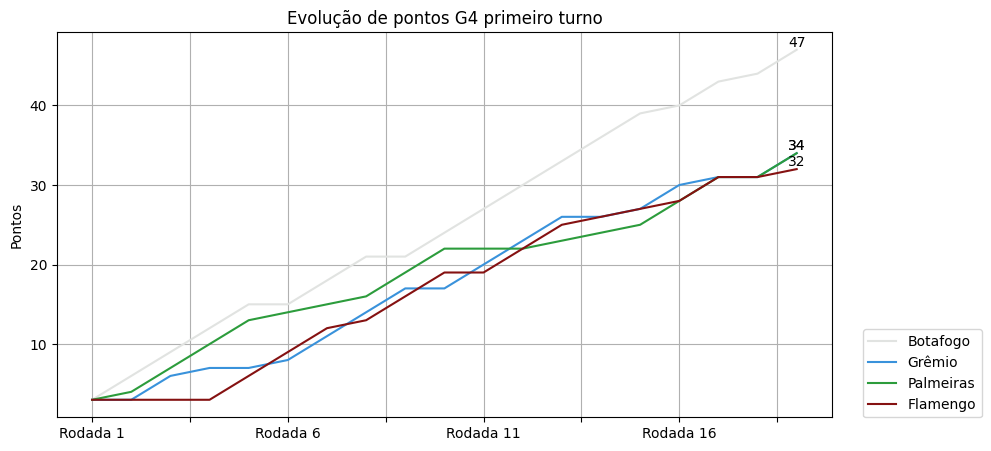

In [ ]:
#Print evolução G4 do primeiro turno
#G4 definition
G4_teams = [
    "Botafogo",
    "Grêmio",
    "Palmeiras",
    "Flamengo"
]

G4_points_df = points_df[G4_teams].copy()

G4_colors = {key: colors[key] for key in G4_teams if key in colors}

#plot
# G4 evolution plot
ax = G4_points_df[first_half].plot(kind="line", figsize=(10, 5), color = G4_colors)

label = 'Rodada 19'

for team in G4_teams:
    pontos = G4_points_df.loc[label][team]
    x_index = G4_points_df.index.get_loc(label)
    ax.text(x_index, pontos , f'{pontos}', va= 'bottom', ha= 'center')

plt.title('Evolução de pontos G4 primeiro turno')
plt.xlabel('')
plt.ylabel('Pontos')
plt.grid(True)
plt.legend(loc=(1.04, 0))

plt.show()

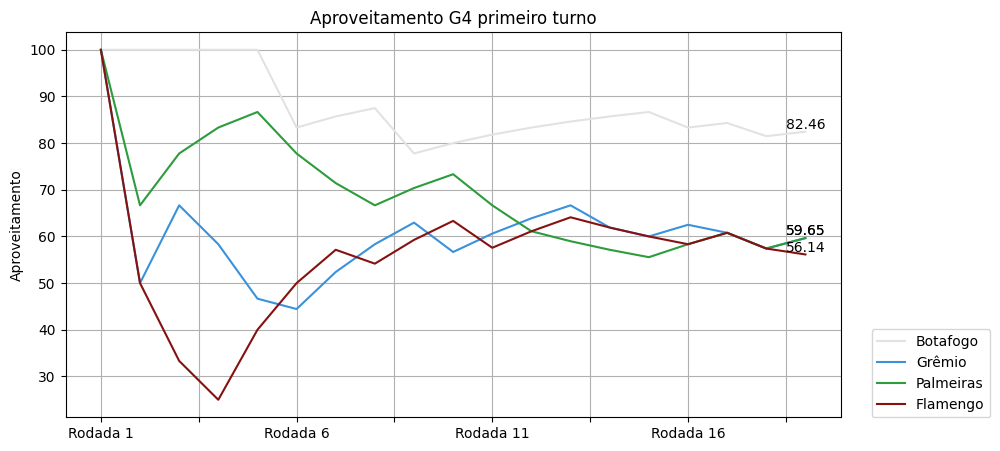

In [ ]:
# Aproveitamento G4 Primeiro Turno
G4_aproveitamento_df = G4_points_df.copy()
max_aproveitamento = range(3, 3*final_round + 1, 3)
if len(max_aproveitamento) == len(G4_aproveitamento_df):
    for column in G4_aproveitamento_df.columns:
        G4_aproveitamento_df[column] = G4_aproveitamento_df[column] / max_aproveitamento * 100

    ax = G4_aproveitamento_df[first_half].plot(kind="line", figsize=(10, 5), color = G4_colors)

    label = 'Rodada 19'

    for team in G4_teams:
        pontos = G4_aproveitamento_df.loc[label][team]
        x_index = G4_aproveitamento_df.index.get_loc(label)
        ax.text(x_index, pontos , f'{pontos:.2f}', va= 'bottom', ha= 'center')

    plt.title('Aproveitamento G4 primeiro turno')
    plt.xlabel('')
    plt.ylabel('Aproveitamento')
    plt.grid(True)
    plt.legend(loc=(1.04, 0))

    plt.show()
else:
    print('data with different lengths')

In [ ]:
teams_evolution['Botafogo'][8:19]

[[21, 7, 0, 2, 9, 16, 7, 9],
 [24, 8, 0, 2, 11, 18, 7, 10],
 [27, 9, 0, 2, 12, 19, 7, 11],
 [30, 10, 0, 2, 13, 20, 7, 12],
 [33, 11, 0, 2, 15, 22, 7, 13],
 [36, 12, 0, 2, 17, 24, 7, 14],
 [39, 13, 0, 2, 19, 26, 7, 15],
 [40, 13, 1, 2, 19, 28, 9, 16],
 [43, 14, 1, 2, 22, 32, 10, 17],
 [44, 14, 2, 2, 22, 32, 10, 18],
 [47, 15, 2, 2, 24, 35, 11, 19]]

In [ ]:
# Perdeu em casa Primeiro Turno
all_matches[(all_matches['championship_round_id'] <= 19) & (all_matches['home_team_name'] == 'Botafogo') & (all_matches['home_team_score']<all_matches['away_team_score'])]

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name


In [ ]:
# Empatou em casa Primeiro Turno
all_matches[(all_matches['championship_round_id'] <= 19) & (all_matches['home_team_name'] == 'Botafogo') & (all_matches['home_team_score']==all_matches['away_team_score'])]

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name


In [ ]:
# Todos os jogos em casa Primeiro Turno
all_matches[(all_matches['championship_round_id'] <= 19) & (all_matches['home_team_name'] == 'Botafogo')]

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name
2,2023-04-15,18:30,Botafogo,São Paulo,2,1,1,Nilton Santos (Engenhão)
36,2023-05-07,18:30,Botafogo,Atlético-MG,2,0,4,Nilton Santos (Engenhão)
48,2023-05-11,19:30,Botafogo,Corinthians,3,0,5,Nilton Santos (Engenhão)
61,2023-05-20,18:30,Botafogo,Fluminense,1,0,7,Nilton Santos (Engenhão)
79,2023-05-28,19:00,Botafogo,América-MG,2,0,8,Nilton Santos (Engenhão)
94,2023-06-10,21:00,Botafogo,Fortaleza,2,0,10,Nilton Santos (Engenhão)
125,2023-07-02,16:00,Botafogo,Vasco,2,0,13,Nilton Santos (Engenhão)
140,2023-07-15,21:00,Botafogo,Bragantino,2,0,15,Nilton Santos (Engenhão)
167,2023-07-30,16:00,Botafogo,Coritiba,4,1,17,Nilton Santos (Engenhão)
180,2023-08-12,21:00,Botafogo,Internacional,3,1,19,Nilton Santos (Engenhão)


In [ ]:
# Perdeu Fora de casa Primeiro Turno
all_matches[(all_matches['championship_round_id'] <= 19) & (all_matches['away_team_name'] == 'Botafogo') & (all_matches['home_team_score']>all_matches['away_team_score'])]

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name
57,2023-05-14,18:30,Goiás,Botafogo,2,1,6,Hailé Pinheiro (Serrinha)
82,2023-06-03,18:30,Athletico-PR,Botafogo,1,0,9,Ligga Arena


In [ ]:
# Todos os jogos do segundo turno
all_matches[(all_matches['championship_round_id'] > 19) & ((all_matches['home_team_name'] == 'Botafogo') | (all_matches['away_team_name'] == 'Botafogo'))]

,date,time,home_team_name,away_team_name,home_team_score,away_team_score,championship_round_id,stadium_name
190,2023-08-19,16:00,São Paulo,Botafogo,0,0,20,Morumbi
203,2023-08-27,16:00,Botafogo,Bahia,3,0,21,Nilton Santos (Engenhão)
212,2023-09-02,21:00,Botafogo,Flamengo,1,2,22,Nilton Santos (Engenhão)
229,2023-09-16,21:00,Atlético-MG,Botafogo,1,0,23,Arena MRV
238,2023-09-22,20:00,Corinthians,Botafogo,1,0,24,Neo Química Arena
249,2023-10-02,20:00,Botafogo,Goiás,1,1,25,Nilton Santos (Engenhão)
253,2023-10-08,16:00,Fluminense,Botafogo,0,2,26,Maracanã
262,2023-10-18,20:00,América-MG,Botafogo,1,2,27,Independência
273,2023-10-22,15:00,Botafogo,Athletico-PR,1,1,28,Nilton Santos (Engenhão)
289,2023-11-23,19:00,Fortaleza,Botafogo,2,2,29,Castelão (CE)


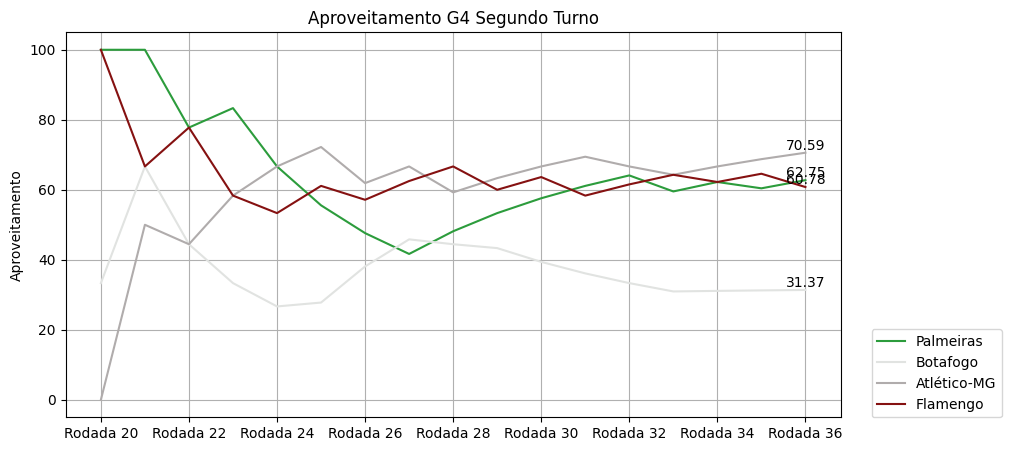

In [ ]:
#Aproveitamento Botafogo Segundo Turno
G4_teams_2o_turno = [
    'Palmeiras',
    'Botafogo',
    'Atlético-MG',
    'Flamengo'
]

G4_aproveitamento_2o_turno_df = points_df[G4_teams_2o_turno]
max_aproveitamento = range(3, 3*(final_round-19) + 1, 3)

resultado_1o_turno = G4_aproveitamento_2o_turno_df.loc['Rodada 19']

G4_aproveitamento_2o_turno_df = G4_aproveitamento_2o_turno_df - resultado_1o_turno

G4_aproveitamento_2o_turno_df = G4_aproveitamento_2o_turno_df.iloc[19:final_round]

G4_colors = {key: colors[key] for key in G4_teams_2o_turno if key in colors}

if len(max_aproveitamento) == len(G4_aproveitamento_2o_turno_df):
    for column in G4_aproveitamento_2o_turno_df.columns:
        G4_aproveitamento_2o_turno_df[column] = G4_aproveitamento_2o_turno_df[column] / max_aproveitamento * 100

    ax = G4_aproveitamento_2o_turno_df.plot(kind="line", figsize=(10, 5), color = G4_colors)

    label = 'Rodada ' + str(final_round)

    for team in G4_teams_2o_turno:
        pontos = G4_aproveitamento_2o_turno_df.loc[label][team]
        x_index = G4_aproveitamento_2o_turno_df.index.get_loc(label)
        ax.text(x_index, pontos , f'{pontos:.2f}', va= 'bottom', ha= 'center')

    plt.title('Aproveitamento G4 Segundo Turno')
    plt.xlabel('')
    plt.ylabel('Aproveitamento')
    plt.grid(True)
    plt.legend(loc=(1.04, 0))

    plt.show()
else:
    print('data with different lengths')

In [44]:
# Pie Chart de Resultados Botafogo 1o Turno

def get_pie_chart(team, round):
    stats = teams_evolution[team][round-1]
    victories = stats[1]
    draws = stats[2]
    losses = stats[3]
    labels = ['Vitórias', 'Empates', 'Derrotas']
    sizes = [victories, draws, losses]  # The percentages of each part of the pie
    colors = ['green', 'yellow', 'red']  # Colors for each section
    explode = (0.1, 0, 0)  # "Explode" the 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    #plt.title('Resultados '+team+' Rodada '+str(round))

    plt.show()


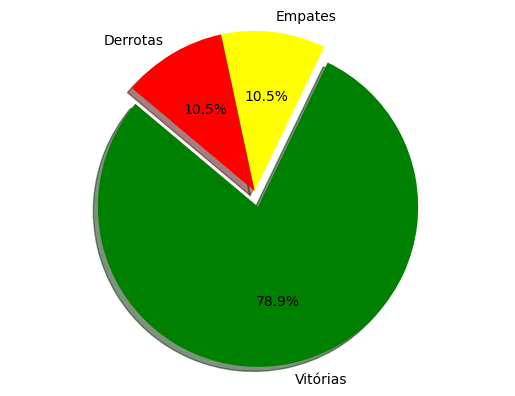

In [45]:
get_pie_chart('Botafogo', 19)

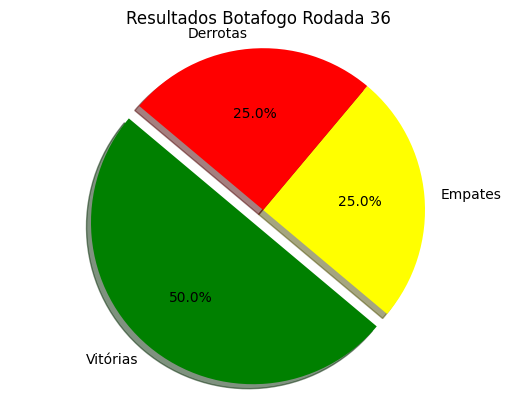

In [36]:
get_pie_chart('Botafogo', final_round)

In [47]:
def get_pie_chart_2o_turno(team, round):
    stats_now = teams_evolution[team][round-1]
    stats_then = teams_evolution[team][18]
    victories = stats_now[1] - stats_then[1]
    draws = stats_now[2] - stats_then[2]
    losses = stats_now[3] - stats_then[3]
    labels = ['Vitórias', 'Empates', 'Derrotas']
    sizes = [victories, draws, losses]  # The percentages of each part of the pie
    colors = ['green', 'yellow', 'red']  # Colors for each section
    explode = (0.1, 0, 0)  # "Explode" the 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    #plt.title('Resultados 2o Turno '+team+' Rodada '+str(round))

    plt.show()

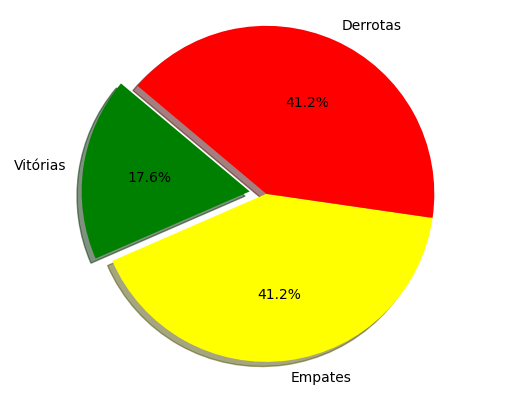

In [48]:
get_pie_chart_2o_turno('Botafogo', final_round)